# The Premise

After building a lot of different models for solving a problem and tracking their results, you'll start to notice how quickly it can get out of hand.

How do we know which model performs the best?

<img src="assets/Models.png" alt="The WorkFlow" width="1000">

The whole point of experiment tracking is helping us compare and analyze what techniques, architectures works and doesn't for the problem at hand

<img src="assets/More and Less.png" alt="The WorkFlow" width="1000">

There's a lot of ways to do this, tensor board, weights & biases, MLflow to name a few.

We will build several models for classifying pizza, steak, and sushi. Then perform experiment tracking with Tensor board, as it is integrated as part of pytorch.

PS - Tensor board was originally developed for Tensor Flow, but Pytorch can still use it

# The Data

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
def set_seeds(seed: int = 42):
    
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [5]:
import os
import zipfile
import requests
from pathlib import Path

def download_data (source: str,
                   destination: str, 
                   remove_source: bool = True) -> Path:
    
    data_path = Path("data/")
    image_path = data_path / destination


    # if the data isn't downloaded yet
    if image_path.is_dir() == False:

        image_path.mkdir(parents=True, exist_ok=True)
        target_file = Path(source).name

        # download the zip file
        with open(data_path / target_file, "wb") as the_zip:
            request = requests.get(source)
            the_zip.write(request.content)

        # unzip the zip
        with zipfile.ZipFile(data_path / target_file, "r") as the_zip:
            the_zip.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
        


    # if the data is already there you don't need to do anything
    else:
        pass


    return image_path

In [35]:
download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")

## Transforms

We will continue using the transfer learning model by default, so uh... yeah it's a copy and paste time

In [36]:
import torchvision

#what weights do we use? which model? (Default just means the best performing weights)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [37]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## DataLoaders

In [59]:
from pathlib import Path

# Setup path to data folder
data_path = Path("Data/pizza_steak_sushi")

# Setup Dirs
train_dir = data_path / "train"
test_dir = data_path / "test"

In [39]:
from going_modular import data_setup

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=auto_transforms, batch_size=32)

# Transfer Learning (The Model)

Same stuff...

In [40]:
model = torchvision.models.efficientnet_b0(weights=weights)

In [41]:
for param in model.features.parameters():
    param.requires_grad = False

set_seeds()

#Update the classifier part of the model
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True).to(device))

# The Training

## Writer Intro (Track Training of 1 model)

In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

It's literally all the same up to this point, training that pre-trained model a bit further

But finally, we get introduced to Tensor Board! You can read it's details over at https://www.tensorflow.org/tensorboard

We can use PyTorch's `torch.utils.).SummaryWriter()` class to save various parts of our model's training progress to file.

By default, these logs are saved to some location under `run` in the current working directory, but of course, you can change where your experiments are tracked and the file names

In [43]:
from torch.utils.tensorboard import SummaryWriter

#create default tensorboard writer
writer = SummaryWriter()

So our goal right now, is update the train function in engine.py, to incorporate Tensor Board to do the logging instead of just returning results as a list

This is the new part added to the function, Tensor Board get's to:

- keep track of the training loss of a model at every epoch
- keep track of the training accuracy of a model at every epoch
- kep track of the model architecture



(don't run the cell, this code is part of function)

In [ ]:
# Add loss results to SummaryWriter
writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train_loss": train_loss,"test_loss": test_loss}, global_step=epoch)

# Add accuracy results to SummaryWriter
writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train_acc": train_acc,"test_acc": test_acc}, global_step=epoch)

# Track the PyTorch model architecture, with an example input of random numbers
writer.add_graph(model=model, input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
# Close the writer
writer.close()

Training the model... then we will see what Tensor Board has got to show us

In [45]:
from going_modular import engine

set_seeds()
model = model.to(device)

results = engine.train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device,
                writer=writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398


 10%|█         | 1/10 [00:11<01:45, 11.70s/it]

Epoch: 2 | train_loss: 0.8975 | train_acc: 0.6562 | test_loss: 0.7837 | test_acc: 0.8561


 20%|██        | 2/10 [00:22<01:28, 11.11s/it]

Epoch: 3 | train_loss: 0.8038 | train_acc: 0.7461 | test_loss: 0.6723 | test_acc: 0.8864


 30%|███       | 3/10 [00:33<01:16, 11.00s/it]

Epoch: 4 | train_loss: 0.6770 | train_acc: 0.8516 | test_loss: 0.6699 | test_acc: 0.8049


 40%|████      | 4/10 [00:43<01:03, 10.61s/it]

Epoch: 5 | train_loss: 0.7065 | train_acc: 0.7188 | test_loss: 0.6746 | test_acc: 0.7737


 50%|█████     | 5/10 [00:53<00:52, 10.49s/it]

Epoch: 6 | train_loss: 0.5952 | train_acc: 0.7656 | test_loss: 0.5910 | test_acc: 0.8655


 60%|██████    | 6/10 [01:03<00:41, 10.38s/it]

Epoch: 7 | train_loss: 0.5388 | train_acc: 0.9297 | test_loss: 0.5386 | test_acc: 0.8561


 70%|███████   | 7/10 [01:13<00:30, 10.30s/it]

Epoch: 8 | train_loss: 0.5446 | train_acc: 0.8086 | test_loss: 0.5311 | test_acc: 0.8561


 80%|████████  | 8/10 [01:23<00:20, 10.22s/it]

Epoch: 9 | train_loss: 0.4831 | train_acc: 0.8125 | test_loss: 0.5166 | test_acc: 0.8665


 90%|█████████ | 9/10 [01:34<00:10, 10.19s/it]

Epoch: 10 | train_loss: 0.4149 | train_acc: 0.9531 | test_loss: 0.4505 | test_acc: 0.8968


100%|██████████| 10/10 [01:44<00:00, 10.41s/it]


So how do we see tensorboard's stuff?

- The button from the vscode extension `Launch TensorBoard Session` doesn't work

- You have to load it from this line `tensorboard --logdir "Path to tensorboard files"`

- But make sure to first load the extension of tensorboard with the line `%load_ext tensorboard`

Also, you can load the line `tensorboard --logdir "Path to tensorboard files"` into CMD, which will return a local link that can be opened in the browser

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "D:\1. Python (AI)\1. Tutorials\4. Machine Learning Libraries\1. Pytorch\8. Experiment_Tracking\runs"

The "kill" thing... you'll have to delete the logs manually at `"AppData/Local/Temp/.tensorboard-info"` to not reuse TensorBoard on port x

Additionally, you can kill the process in PowerShell using `taskkill /F /PID x` to kill it, where x is the PID of the TensorBoard session

PS - For some reason, I can't see the tensorboard in jupyter notebook when it reuses an existing tensorboard session, and I have to manually delete the log and let it create a new one

There's a lot of things that you can fiddle around and check out here, time series can see your metrics that change over time, such as loss and accuracy during training

Or graphs, which give you a visualization of the structure of your models, the layers, the operations, the flow of tensors...

There's still a lot that's not covered, like images, distributions... these all come around when solving other problems and building other models

## Writer in Detail (Customizing how we track training for anything)

At the end of the day, the purpose of the TensorBoard SummaryWriter in PyTorch is to record data from your machine learning training process, that's called logging

It serves as a bridge between your model experiment code and TensorBoard, allowing you to log various types of information that can be visualized and analyzed through the TensorBoard interface.

Basically "What do I record down during the machine learning workflow?", so there's more to play around with!

Let's write a Summary Writer Creator that can allow each experiment to get its own logs directory (It's not a dead rule, it's just 1 way to distinguish experiments from experiments)

Each directory's unique name should include some information about itself:

- Experiment Date
- Experiment Name
- Model Name
- Other Things

In [6]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                  model_name: str,
                  info: str = None):

    from datetime import datetime
    import os
    
    #Get Current Time
    time = datetime.now().strftime("%Y-%m-%d")

    #Get Current Dir
    current_dir = os.getcwd()
    
    #See if there is extra info, concatenate to dir string name
    if info:
        log_dir = os.path.join("runs", time, experiment_name, model_name, info)
    else:
        log_dir = os.path.join("runs", time, experiment_name, model_name)

    return SummaryWriter(log_dir=log_dir)


How About Let's run some experiments, and models utilizing this writer function?

There's a lot that you can test:

- Change epochs trained
- Change architecture
- Change hyper parameters
- Change dataset
- and whatever stuff that you changed

But, still remember, it's all for making the best model for the job

## Trying and Recording Different Experiments 

Like as said, there's a lot of potential experiments that we can run, so we'll run the following:

1. A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. A different model size (torchvision.models.efficientnet_b0 vs. torchvision.models.efficientnet_b2)
3. A different training time (5 epochs vs. 10 epochs)

There will be a total of 6 different combinations:

<img src="assets/Combinations.png" alt="The WorkFlow" width="1000">

Do note that the test data will be the same across all experiments for consistency in comparison

## Download Data

In [7]:
#You might wonder "wait, isn't this just the default dataset?", Yes but it's 10% of the original dataset
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip", destination="pizza_steak_sushi_20_percent")

print(data_10_percent_path)
print(data_20_percent_path)

data\pizza_steak_sushi
data\pizza_steak_sushi_20_percent


## Dataloaders

First me must apply a transforms to them, but the different models use a different transforms

In [8]:
import torchvision

weights_B0 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights_B2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT

In [9]:
transforms_B0 = weights_B0.transforms()
transforms_B0

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
transforms_B2 = weights_B2.transforms()
transforms_B2

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Setting up where the training/testing data should come from

In [11]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

Now we will create the dataloaders for the respective 10% data, and 20% data, because their transforms is different

In [12]:
from going_modular import data_setup


BATCH_SIZE = 32


# Create 10% training and test DataLoaders, for Effnet_B0
train_dataloader_10_percent_B0, test_dataloader_B0, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent, test_dir=test_dir, transform=transforms_B0, batch_size=BATCH_SIZE)

# Create 20% training and test DataLoders, for Effnet_B0
train_dataloader_20_percent_B0, test_dataloader_B0, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent, test_dir=test_dir, transform=transforms_B0, batch_size=BATCH_SIZE)

# Create 10% training and test DataLoaders, for Effnet_B2
train_dataloader_10_percent_B2, test_dataloader_B2, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent, test_dir=test_dir, transform=transforms_B2, batch_size=BATCH_SIZE)

# Create 20% training and test DataLoders, for Effnet_B2
train_dataloader_20_percent_B2, test_dataloader_B2, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent, test_dir=test_dir, transform=transforms_B2, batch_size=BATCH_SIZE)


# Find the number of samples/batches per dataloader 
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data of Effnet_B0: {len(train_dataloader_10_percent_B0)}")
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data of Effnet_B2: {len(train_dataloader_10_percent_B2)}")

print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data of Effnet_B0: {len(train_dataloader_20_percent_B0)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data of Effnet_B2: {len(train_dataloader_20_percent_B2)}")

print(f"Number of batches of size {BATCH_SIZE} in testing data for Effnet_B0: {len(test_dataloader_B0)} (all experiments will use the same test dataset, transforms will vary per model)")
print(f"Number of batches of size {BATCH_SIZE} in testing data for Effnet_B2: {len(test_dataloader_B2)} (all experiments will use the same test dataset, transforms will vary per model)")

print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data of Effnet_B0: 8
Number of batches of size 32 in 10 percent training data of Effnet_B2: 8
Number of batches of size 32 in 20 percent training data of Effnet_B0: 15
Number of batches of size 32 in 20 percent training data of Effnet_B2: 15
Number of batches of size 32 in testing data for Effnet_B0: 3 (all experiments will use the same test dataset, transforms will vary per model)
Number of batches of size 32 in testing data for Effnet_B2: 3 (all experiments will use the same test dataset, transforms will vary per model)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


## Create Models

The same idea, we grab the pre-trained models, change the parameters to be frozen, and change the output layer to suit out problem (of classifying pizza, steak, sushi)

In [13]:
import torchvision
from torch import nn


# Create an EffNetB0 feature extractor
def create_effnetb0(out_features: int,
                    device: str):
    
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=out_features)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model


# Create an EffNetB2 feature extractor
def create_effnetb2(out_features: int,
                    device: str):
    
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=out_features)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

## Run Training

If you remember, there should be 8 experiments in total from these combinations

In [15]:
from going_modular import engine
from going_modular import utils

# Creating lists and dicts to iterate through
train_dataloaders = {"data_10_percent_B0": train_dataloader_10_percent_B0,
                     "data_10_percent_B2": train_dataloader_10_percent_B2,
                     "data_20_percent_B0": train_dataloader_20_percent_B0,
                     "data_20_percent_B2": train_dataloader_20_percent_B2}

test_dataloaders = {"test_dataloader_B0": test_dataloader_B0,
                    "test_dataloader_B2": test_dataloader_B2}

models = ["effnetb0", "effnetb2"]
train_percent = ["10_percent", "20_percent"]
num_epochs = [5, 10]


# Set the random seeds
set_seeds(seed=42)

# Keep track of experiment numbers
experiment_number = 0



# Loop through training data percentages
for percent in train_percent:

    # Loop through each model name
    for model_name in models:

        # Determine which data_loader we are using
        if model_name == "effnetb0":
            dataloader_name = f"data_{percent}_B0"
            test_dataloader = test_dataloaders["test_dataloader_B0"]
        else:
            dataloader_name = f"data_{percent}_B2"
            test_dataloader = test_dataloaders["test_dataloader_B2"]

        train_dataloader = train_dataloaders[dataloader_name]

        # Loop through each number of epochs, and create a new model based on the name
        for epochs in num_epochs:


            # Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")


            # Creates a new model each time (important because we want each experiment to start from scratch)
            if model_name == "effnetb0":
                model = create_effnetb0(out_features=3, device=device)
            else:
                model = create_effnetb2(out_features=3, device=device)


            # Create a new loss function, optimizer and writer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            writer = create_writer(experiment_name=dataloader_name, model_name=model_name, info=f"{epochs}_epochs")


            # Train target model with target dataloaders and track experiments
            engine.train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=epochs, device=device, writer=writer)


            # Save the model to a file so we can get back the best model
            save_filepath = f"{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            utils.save_model(model=model, target_dir="models", model_name=save_filepath)
            print("-" * 50 + "\n")


            

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent_B0
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0362 | train_acc: 0.4961 | test_loss: 0.8665 | test_acc: 0.6723


 20%|██        | 1/5 [00:13<00:52, 13.09s/it]

Epoch: 2 | train_loss: 0.9294 | train_acc: 0.5625 | test_loss: 0.8183 | test_acc: 0.6723


 40%|████      | 2/5 [00:25<00:38, 12.85s/it]

Epoch: 3 | train_loss: 0.8302 | train_acc: 0.7031 | test_loss: 0.7117 | test_acc: 0.8561


 60%|██████    | 3/5 [00:36<00:23, 11.84s/it]

Epoch: 4 | train_loss: 0.7197 | train_acc: 0.7773 | test_loss: 0.6199 | test_acc: 0.8864


 80%|████████  | 4/5 [00:47<00:11, 11.45s/it]

Epoch: 5 | train_loss: 0.5888 | train_acc: 0.8828 | test_loss: 0.5871 | test_acc: 0.8248


100%|██████████| 5/5 [00:58<00:00, 11.63s/it]


[INFO] Saving model to: models\effnetb0_data_10_percent_B0_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent_B0
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0362 | train_acc: 0.4961 | test_loss: 0.8665 | test_acc: 0.6723


 10%|█         | 1/10 [00:10<01:35, 10.60s/it]

Epoch: 2 | train_loss: 0.9294 | train_acc: 0.5625 | test_loss: 0.8183 | test_acc: 0.6723


 20%|██        | 2/10 [00:21<01:25, 10.74s/it]

Epoch: 3 | train_loss: 0.8302 | train_acc: 0.7031 | test_loss: 0.7117 | test_acc: 0.8561


 30%|███       | 3/10 [00:31<01:14, 10.64s/it]

Epoch: 4 | train_loss: 0.7197 | train_acc: 0.7773 | test_loss: 0.6199 | test_acc: 0.8864


 40%|████      | 4/10 [00:42<01:04, 10.74s/it]

Epoch: 5 | train_loss: 0.5888 | train_acc: 0.8828 | test_loss: 0.5871 | test_acc: 0.8248


 50%|█████     | 5/10 [00:53<00:53, 10.74s/it]

Epoch: 6 | train_loss: 0.5552 | train_acc: 0.8438 | test_loss: 0.6118 | test_acc: 0.7945


 60%|██████    | 6/10 [01:04<00:42, 10.74s/it]

Epoch: 7 | train_loss: 0.6131 | train_acc: 0.7617 | test_loss: 0.5969 | test_acc: 0.8456


 70%|███████   | 7/10 [01:15<00:32, 10.74s/it]

Epoch: 8 | train_loss: 0.4832 | train_acc: 0.9297 | test_loss: 0.5297 | test_acc: 0.8352


 80%|████████  | 8/10 [01:25<00:21, 10.73s/it]

Epoch: 9 | train_loss: 0.4611 | train_acc: 0.9219 | test_loss: 0.5178 | test_acc: 0.8248


 90%|█████████ | 9/10 [01:36<00:10, 10.72s/it]

Epoch: 10 | train_loss: 0.5444 | train_acc: 0.7734 | test_loss: 0.4828 | test_acc: 0.8655


100%|██████████| 10/10 [01:47<00:00, 10.71s/it]


[INFO] Saving model to: models\effnetb0_data_10_percent_B0_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent_B2
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0934 | train_acc: 0.3594 | test_loss: 0.9343 | test_acc: 0.6723


 20%|██        | 1/5 [00:12<00:48, 12.15s/it]

Epoch: 2 | train_loss: 0.8868 | train_acc: 0.6836 | test_loss: 0.8671 | test_acc: 0.6828


 40%|████      | 2/5 [00:24<00:37, 12.39s/it]

Epoch: 3 | train_loss: 0.8164 | train_acc: 0.6992 | test_loss: 0.7564 | test_acc: 0.8059


 60%|██████    | 3/5 [00:37<00:24, 12.35s/it]

Epoch: 4 | train_loss: 0.6964 | train_acc: 0.8711 | test_loss: 0.6393 | test_acc: 0.9072


 80%|████████  | 4/5 [00:49<00:12, 12.35s/it]

Epoch: 5 | train_loss: 0.6976 | train_acc: 0.7578 | test_loss: 0.5813 | test_acc: 0.8968


100%|██████████| 5/5 [01:01<00:00, 12.37s/it]


[INFO] Saving model to: models\effnetb2_data_10_percent_B2_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent_B2
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0934 | train_acc: 0.3594 | test_loss: 0.9343 | test_acc: 0.6723


 10%|█         | 1/10 [00:12<01:49, 12.16s/it]

Epoch: 2 | train_loss: 0.8868 | train_acc: 0.6836 | test_loss: 0.8671 | test_acc: 0.6828


 20%|██        | 2/10 [00:24<01:38, 12.36s/it]

Epoch: 3 | train_loss: 0.8164 | train_acc: 0.6992 | test_loss: 0.7564 | test_acc: 0.8059


 30%|███       | 3/10 [00:36<01:26, 12.30s/it]

Epoch: 4 | train_loss: 0.6964 | train_acc: 0.8711 | test_loss: 0.6393 | test_acc: 0.9072


 40%|████      | 4/10 [00:48<01:13, 12.21s/it]

Epoch: 5 | train_loss: 0.6976 | train_acc: 0.7578 | test_loss: 0.5813 | test_acc: 0.8968


 50%|█████     | 5/10 [01:01<01:01, 12.28s/it]

Epoch: 6 | train_loss: 0.5846 | train_acc: 0.9102 | test_loss: 0.6065 | test_acc: 0.8977


 60%|██████    | 6/10 [01:13<00:49, 12.29s/it]

Epoch: 7 | train_loss: 0.5646 | train_acc: 0.8281 | test_loss: 0.5538 | test_acc: 0.8977


 70%|███████   | 7/10 [01:25<00:36, 12.29s/it]

Epoch: 8 | train_loss: 0.5285 | train_acc: 0.8281 | test_loss: 0.5344 | test_acc: 0.9081


 80%|████████  | 8/10 [01:38<00:24, 12.36s/it]

Epoch: 9 | train_loss: 0.4680 | train_acc: 0.8047 | test_loss: 0.4996 | test_acc: 0.9280


 90%|█████████ | 9/10 [01:50<00:12, 12.40s/it]

Epoch: 10 | train_loss: 0.4930 | train_acc: 0.8242 | test_loss: 0.5096 | test_acc: 0.9081


100%|██████████| 10/10 [02:03<00:00, 12.34s/it]


[INFO] Saving model to: models\effnetb2_data_10_percent_B2_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent_B0
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9483 | train_acc: 0.5875 | test_loss: 0.6605 | test_acc: 0.8968


 20%|██        | 1/5 [00:11<00:46, 11.65s/it]

Epoch: 2 | train_loss: 0.7120 | train_acc: 0.7708 | test_loss: 0.5541 | test_acc: 0.9280


 40%|████      | 2/5 [00:23<00:34, 11.56s/it]

Epoch: 3 | train_loss: 0.5682 | train_acc: 0.8417 | test_loss: 0.4889 | test_acc: 0.9081


 60%|██████    | 3/5 [00:34<00:23, 11.52s/it]

Epoch: 4 | train_loss: 0.4602 | train_acc: 0.8938 | test_loss: 0.4102 | test_acc: 0.9375


 80%|████████  | 4/5 [00:45<00:11, 11.45s/it]

Epoch: 5 | train_loss: 0.4413 | train_acc: 0.8812 | test_loss: 0.3858 | test_acc: 0.9176


100%|██████████| 5/5 [00:57<00:00, 11.45s/it]


[INFO] Saving model to: models\effnetb0_data_20_percent_B0_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent_B0
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9483 | train_acc: 0.5875 | test_loss: 0.6605 | test_acc: 0.8968


 10%|█         | 1/10 [00:11<01:41, 11.29s/it]

Epoch: 2 | train_loss: 0.7120 | train_acc: 0.7708 | test_loss: 0.5541 | test_acc: 0.9280


 20%|██        | 2/10 [00:22<01:30, 11.34s/it]

Epoch: 3 | train_loss: 0.5682 | train_acc: 0.8417 | test_loss: 0.4889 | test_acc: 0.9081


 30%|███       | 3/10 [00:33<01:19, 11.32s/it]

Epoch: 4 | train_loss: 0.4602 | train_acc: 0.8938 | test_loss: 0.4102 | test_acc: 0.9375


 40%|████      | 4/10 [00:45<01:08, 11.37s/it]

Epoch: 5 | train_loss: 0.4413 | train_acc: 0.8812 | test_loss: 0.3858 | test_acc: 0.9176


 50%|█████     | 5/10 [00:56<00:56, 11.33s/it]

Epoch: 6 | train_loss: 0.4141 | train_acc: 0.8917 | test_loss: 0.3846 | test_acc: 0.8977


 60%|██████    | 6/10 [01:07<00:45, 11.32s/it]

Epoch: 7 | train_loss: 0.3523 | train_acc: 0.9021 | test_loss: 0.3428 | test_acc: 0.8977


 70%|███████   | 7/10 [01:19<00:33, 11.32s/it]

Epoch: 8 | train_loss: 0.3276 | train_acc: 0.9250 | test_loss: 0.3339 | test_acc: 0.9081


 80%|████████  | 8/10 [01:31<00:22, 11.49s/it]

Epoch: 9 | train_loss: 0.3649 | train_acc: 0.8833 | test_loss: 0.3501 | test_acc: 0.8977


 90%|█████████ | 9/10 [01:42<00:11, 11.45s/it]

Epoch: 10 | train_loss: 0.3755 | train_acc: 0.8938 | test_loss: 0.2887 | test_acc: 0.9176


100%|██████████| 10/10 [01:54<00:00, 11.40s/it]


[INFO] Saving model to: models\effnetb0_data_20_percent_B0_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent_B2
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9794 | train_acc: 0.5833 | test_loss: 0.7420 | test_acc: 0.8864


 20%|██        | 1/5 [00:13<00:53, 13.47s/it]

Epoch: 2 | train_loss: 0.6942 | train_acc: 0.8083 | test_loss: 0.6118 | test_acc: 0.8769


 40%|████      | 2/5 [00:26<00:40, 13.48s/it]

Epoch: 3 | train_loss: 0.5364 | train_acc: 0.8958 | test_loss: 0.4980 | test_acc: 0.8873


 60%|██████    | 3/5 [00:40<00:26, 13.47s/it]

Epoch: 4 | train_loss: 0.5177 | train_acc: 0.8271 | test_loss: 0.4725 | test_acc: 0.8873


 80%|████████  | 4/5 [00:53<00:13, 13.47s/it]

Epoch: 5 | train_loss: 0.4528 | train_acc: 0.8688 | test_loss: 0.3949 | test_acc: 0.9176


100%|██████████| 5/5 [01:07<00:00, 13.51s/it]


[INFO] Saving model to: models\effnetb2_data_20_percent_B2_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent_B2
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9794 | train_acc: 0.5833 | test_loss: 0.7420 | test_acc: 0.8864


 10%|█         | 1/10 [00:14<02:09, 14.40s/it]

Epoch: 2 | train_loss: 0.6942 | train_acc: 0.8083 | test_loss: 0.6118 | test_acc: 0.8769


 20%|██        | 2/10 [00:27<01:50, 13.78s/it]

Epoch: 3 | train_loss: 0.5364 | train_acc: 0.8958 | test_loss: 0.4980 | test_acc: 0.8873


 30%|███       | 3/10 [00:40<01:33, 13.38s/it]

Epoch: 4 | train_loss: 0.5177 | train_acc: 0.8271 | test_loss: 0.4725 | test_acc: 0.8873


 40%|████      | 4/10 [00:53<01:18, 13.07s/it]

Epoch: 5 | train_loss: 0.4528 | train_acc: 0.8688 | test_loss: 0.3949 | test_acc: 0.9176


 50%|█████     | 5/10 [01:06<01:05, 13.08s/it]

Epoch: 6 | train_loss: 0.3655 | train_acc: 0.9208 | test_loss: 0.3979 | test_acc: 0.9081


 60%|██████    | 6/10 [01:20<00:53, 13.38s/it]

Epoch: 7 | train_loss: 0.3584 | train_acc: 0.8917 | test_loss: 0.3433 | test_acc: 0.9280


 70%|███████   | 7/10 [01:34<00:40, 13.57s/it]

Epoch: 8 | train_loss: 0.3110 | train_acc: 0.9250 | test_loss: 0.3550 | test_acc: 0.9280


 80%|████████  | 8/10 [01:49<00:28, 14.23s/it]

Epoch: 9 | train_loss: 0.3330 | train_acc: 0.9354 | test_loss: 0.3626 | test_acc: 0.8873


 90%|█████████ | 9/10 [02:04<00:14, 14.44s/it]

Epoch: 10 | train_loss: 0.3738 | train_acc: 0.8792 | test_loss: 0.3163 | test_acc: 0.9176


100%|██████████| 10/10 [02:20<00:00, 14.02s/it]

[INFO] Saving model to: models\effnetb2_data_20_percent_B2_10_epochs.pth
--------------------------------------------------



That took 10 minutes, imagine training a lot of larger models

## View on Tensorboard

In [32]:
%load_ext tensorboard
%tensorboard --logdir "D:\1. Python (AI)\1. Tutorials\4. Machine Learning Libraries\1. Pytorch\8. Experiment_Tracking\runs"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10796), started 0:00:02 ago. (Use '!kill 10796' to kill it.)

There seems to be some errors on the recording of effnetb2's test and train loss, and I really don't know what causes the problem

- `2024-03-03\data_20_percent_B2\effnetb2\5_epochs\Accuracy_test_acc` wasn't recorded correctly

- `2024-03-03\data_20_percent_B2\effnetb2\5_epochs\Loss_test_loss` wasn't recorded correctly



Putting that aside, let's look at some winners

Top 3 Lowest Test Loss:

1. `effnetb0, 10 epochs, 20% data` (0.2887)
2. `effnetb0, 5 epochs, 20% data` (0.3858)
3. `effnetb0, 10 epochs, 10% data` (0.4828)


Top 3 Highest Test Accuracy (They are tied first):

1. `effnetb0, 10 epochs, 20% data` (91.76%)
2. `effnetb0, 5 epochs, 20% data` (91.76%)
3. `effnetb2, 10 epochs, 20% data` (91.76%)


So overall it seems like `effnetb0, 10 epochs, 20% data` is the winner

# Load the best model and predict some images

Import the Best Model

In [35]:
# Setup the best model filepath
best_model_path = "models/effnetb0_data_20_percent_B0_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb0(out_features=3, device=device)

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb0 model.


<All keys matched successfully>

The same function that plots the prediction of the model

In [36]:
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: list[str],
                        transform: torchvision.transforms,
                        device: torch.device=device):
    
    image = Image.open(image_path)

    model.to(device)
    model.eval()

    with torch.inference_mode():
        transformed_image = transform(image).unsqueeze(dim=0)
        predictions = model(transformed_image.to(device))

    predictions_probability = torch.softmax(predictions, dim=1)
    highest_likely_class = torch.argmax(predictions_probability, dim=1)

    max_probability_percentage = predictions_probability.max() * 100

    plt.figure()
    plt.imshow(image)
    plt.title(f"Prediction: {class_names[highest_likely_class]} | Probability: {max_probability_percentage:.2f}%")
    plt.axis(False)

Run for fun

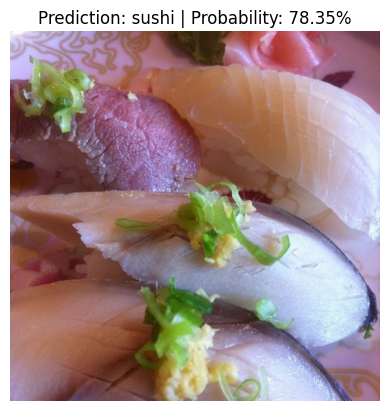

In [85]:
import random

# get list all image paths from train data 
test_image_path_list = list(Path(train_dir).glob("*/*.jpg"))

# get 1 sample from list
sample = random.choice(test_image_path_list)

pred_and_plot_image(model=best_model, image_path=sample, class_names=class_names, transform=transforms_B0, device=device)

Damn, all that for a drop of blood (Thanos Voice)